In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from celluloid import Camera
from collections import deque
from matplotlib import animation

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.semi_random_player import SemiRandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

# %matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

In [3]:
MODEL_VERSION = 'v9'
TRAIN_MODE = 'semi_random' # self_play / random / semi_random
INITIAL_BID_NORMALIZER = 100 # 100 if action is relative to current coins, 200 if relative to total coins

In [4]:
def run_validation(players, n_episodes_validation):
    game_controller = GameController()
    validation_players = [players[0], SemiRandomPlayer(1, game_controller.game)]
    game_controller.load_validation(validation_players)

    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
        game_controller.game.reset()

    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [5]:
def get_critic_value(agent_critic, initial_state, bid, board_move):
    action = torch.zeros(10)
    action[0] = bid/INITIAL_BID_NORMALIZER
    action[1+board_move] = 1
    action = action.unsqueeze(0).cuda()
    return agent_critic(initial_state, action).flatten().item()

def get_all_critic_values(drl_player, initial_state):
    agent_critic = drl_player.agent.agent.critic_local
    return [[get_critic_value(agent_critic, initial_state, bid, board_move) for bid in range(101)] \
                for board_move in range(9)]   

In [6]:
def plot_critic_values(drl_player, critic_values, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(3, 3, figsize=(12, 8))
    for board_move in range(9):
        axx = ax[board_move//3, board_move%3]
        axx.set_xlabel('Bid value')
        axx.set_ylabel('Quality of move')
        axx.set_title(f'Board move {board_move}')
        axx.plot(critic_values[board_move])
    fig.tight_layout()
#     plt.savefig('test.png')

In [7]:
def create_animation(critic_values_by_episode, drl_player, fps=10, filename='critic_values.mp4'):
    fig, ax = plt.subplots(3, 3, figsize=(12, 8))

    camera = Camera(fig)
    initial_index = 0
    while initial_index+1<len(critic_values_by_episode) and \
            critic_values_by_episode[initial_index] == critic_values_by_episode[initial_index+1]:
        initial_index += 1

    for i in range(initial_index, len(critic_values_by_episode)):
        critic_values = critic_values_by_episode[i]
        i += 1
        plot_critic_values(drl_player, critic_values, fig, ax);
        plt.pause(0.1)
        camera.snap()

    anim = camera.animate()
    FFwriter = animation.FFMpegWriter(fps=fps)
    anim.save(filename, writer=FFwriter);

In [8]:
def init_train(game_controller, players, n_episodes, checkpoint_each, validate_each, n_episodes_validation,
                   model_path=None, save_critic_value_each=100, save_animation_each=1000, eps_start=1.0,
                   eps_end=0.01, eps_decay=0.999, start_epoch=1, critic_values_by_episode=None):
        game_controller.load_train(players)

        if critic_values_by_episode is None:
            critic_values_by_episode = []
        initial_state = players[0]._format_state_to_agent(game_controller.game.get_state_array()).cuda().unsqueeze(0)

        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=10)
            eps = eps_start
            start = time.time()
            for i in range(start_epoch, start_epoch+n_episodes):
                game_controller.players[0].update_epsilon(eps)
                if TRAIN_MODE == 'self_play':
                    game_controller.players[1].update_epsilon(eps)

                episode_winner = game_controller.run_episode(train_mode=True)
                game_controller.game.reset()

                # Update epsilon-greedy parameter
                eps = max(eps_end, eps * eps_decay)

                if i%validate_each == 0:
                    mean_validation_score = run_validation(players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    try:
                        agent_losses = players[0].agent.get_losses()
                        actor_loss = '{:+6.3f}'.format(agent_losses['actor_losses'][-1])
                        critic_loss = '{:+6.3f}'.format(agent_losses['critic_losses'][-1])
                    except:
                        actor_loss = '------'
                        critic_loss = '------'
                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}   |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}\n"
                        "                  "
                        "Actor Loss: {}  |  "
                        "Critic Loss: {}     |  "
                        "Time Elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, eps,
                                            actor_loss, critic_loss, time.time() - start)
                    )

                if checkpoint_each != -1 and i%checkpoint_each == 0:
                    players[0].agent.save_model(f'../checkpoints/{MODEL_VERSION}_checkpoint_episode_{i}.pt')
                    print('Checkpoint saved!')
                if save_critic_value_each != -1 and i%save_critic_value_each == 0:
                    critic_values_by_episode.append(get_all_critic_values(players[0], initial_state))
                if save_animation_each != -1 and i%save_animation_each == 0:
                    create_animation(critic_values_by_episode, players[0], filename=f'../animations/{MODEL_VERSION}_critic_values_episode_{i}.mp4')
                    print('Animation of critic values saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores, critic_values_by_episode

In [9]:
def plot_scores(metrics, validate_each):
    new_index = pd.RangeIndex(start=1, stop=1+len(metrics)*validate_each, step=validate_each)
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(new_index, metrics)
    series = pd.Series(metrics)
    series.index = new_index
    series.rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Score')
    plt.show();

In [10]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path=f'../checkpoints/{MODEL_VERSION}_checkpoint.pt'
)

Episode # 100  |  Val. Score: -0.70   |  Avg. Val. Score: -0.70  |  Epsilon: 0.993
                  Actor Loss: ------  |  Critic Loss: ------     |  Time Elapsed: 0.89s
Episode # 200  |  Val. Score: -0.30   |  Avg. Val. Score: -0.50  |  Epsilon: 0.985
                  Actor Loss: +0.068  |  Critic Loss: +0.082     |  Time Elapsed: 24.89s
Episode # 300  |  Val. Score: -0.80   |  Avg. Val. Score: -0.60  |  Epsilon: 0.978
                  Actor Loss: +0.040  |  Critic Loss: +0.071     |  Time Elapsed: 65.21s
Episode # 400  |  Val. Score: -0.40   |  Avg. Val. Score: -0.55  |  Epsilon: 0.970
                  Actor Loss: +0.104  |  Critic Loss: +0.071     |  Time Elapsed: 106.04s
Episode # 500  |  Val. Score: +0.20   |  Avg. Val. Score: -0.40  |  Epsilon: 0.963
                  Actor Loss: +0.164  |  Critic Loss: +0.069     |  Time Elapsed: 148.88s
Checkpoint saved!
Episode # 600  |  Val. Score: -0.20   |  Avg. Val. Score: -0.37  |  Epsilon: 0.956
                  Actor Loss: +0.194  

Episode #4800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.54  |  Epsilon: 0.698
                  Actor Loss: -0.337  |  Critic Loss: +0.110     |  Time Elapsed: 2093.83s
Episode #4900  |  Val. Score: +0.70   |  Avg. Val. Score: +0.59  |  Epsilon: 0.692
                  Actor Loss: -0.363  |  Critic Loss: +0.107     |  Time Elapsed: 2138.86s
Episode #5000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.61  |  Epsilon: 0.687
                  Actor Loss: -0.372  |  Critic Loss: +0.105     |  Time Elapsed: 2185.88s
Checkpoint saved!
Episode #5100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.65  |  Epsilon: 0.682
                  Actor Loss: -0.372  |  Critic Loss: +0.100     |  Time Elapsed: 2231.48s
Episode #5200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.64  |  Epsilon: 0.677
                  Actor Loss: -0.398  |  Critic Loss: +0.106     |  Time Elapsed: 2277.28s
Episode #5300  |  Val. Score: +0.20   |  Avg. Val. Score: +0.61  |  Epsilon: 0.672
                  Actor Loss:

Episode #9500  |  Val. Score: +0.90   |  Avg. Val. Score: +0.56  |  Epsilon: 0.490
                  Actor Loss: -0.436  |  Critic Loss: +0.112     |  Time Elapsed: 4299.67s
Checkpoint saved!
Episode #9600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.62  |  Epsilon: 0.487
                  Actor Loss: -0.472  |  Critic Loss: +0.124     |  Time Elapsed: 4345.98s
Episode #9700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.64  |  Epsilon: 0.483
                  Actor Loss: -0.462  |  Critic Loss: +0.101     |  Time Elapsed: 4392.46s
Episode #9800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.64  |  Epsilon: 0.479
                  Actor Loss: -0.443  |  Critic Loss: +0.115     |  Time Elapsed: 4441.98s
Episode #9900  |  Val. Score: +0.90   |  Avg. Val. Score: +0.65  |  Epsilon: 0.476
                  Actor Loss: -0.448  |  Critic Loss: +0.119     |  Time Elapsed: 4488.73s
Episode #10000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.69  |  Epsilon: 0.472
                  Actor Loss

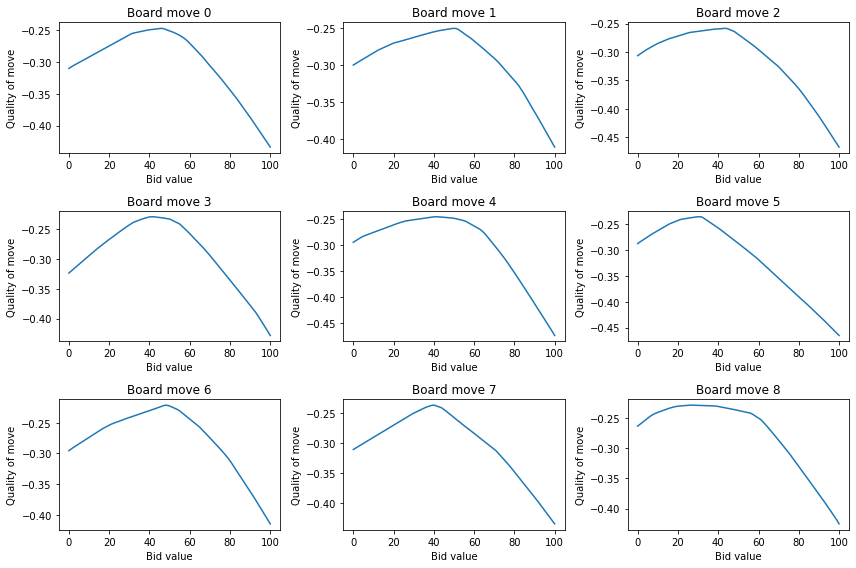

Animation of critic values saved!
Episode #10100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.67  |  Epsilon: 0.469
                  Actor Loss: -0.477  |  Critic Loss: +0.124     |  Time Elapsed: 4588.90s
Episode #10200  |  Val. Score: +0.20   |  Avg. Val. Score: +0.70  |  Epsilon: 0.465
                  Actor Loss: -0.508  |  Critic Loss: +0.113     |  Time Elapsed: 4636.67s
Episode #10300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.70  |  Epsilon: 0.462
                  Actor Loss: -0.530  |  Critic Loss: +0.115     |  Time Elapsed: 4684.22s
Episode #10400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.72  |  Epsilon: 0.458
                  Actor Loss: -0.514  |  Critic Loss: +0.124     |  Time Elapsed: 4733.17s
Episode #10500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.69  |  Epsilon: 0.455
                  Actor Loss: -0.537  |  Critic Loss: +0.112     |  Time Elapsed: 4782.34s
Checkpoint saved!
Episode #10600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.65  |  Epsi

Episode #14700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.74  |  Epsilon: 0.332
                  Actor Loss: -0.542  |  Critic Loss: +0.112     |  Time Elapsed: 6797.23s
Episode #14800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.78  |  Epsilon: 0.330
                  Actor Loss: -0.547  |  Critic Loss: +0.121     |  Time Elapsed: 6845.85s
Episode #14900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.82  |  Epsilon: 0.327
                  Actor Loss: -0.542  |  Critic Loss: +0.104     |  Time Elapsed: 6894.11s
Episode #15000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.82  |  Epsilon: 0.325
                  Actor Loss: -0.527  |  Critic Loss: +0.113     |  Time Elapsed: 6942.19s
Checkpoint saved!
Episode #15100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.80  |  Epsilon: 0.322
                  Actor Loss: -0.525  |  Critic Loss: +0.121     |  Time Elapsed: 6991.76s
Episode #15200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.320
                  Actor

Episode #19300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.64  |  Epsilon: 0.235
                  Actor Loss: -0.613  |  Critic Loss: +0.104     |  Time Elapsed: 9047.74s
Episode #19400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.63  |  Epsilon: 0.233
                  Actor Loss: -0.612  |  Critic Loss: +0.118     |  Time Elapsed: 9096.42s
Episode #19500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.65  |  Epsilon: 0.232
                  Actor Loss: -0.603  |  Critic Loss: +0.117     |  Time Elapsed: 9145.84s
Checkpoint saved!
Episode #19600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.71  |  Epsilon: 0.230
                  Actor Loss: -0.612  |  Critic Loss: +0.119     |  Time Elapsed: 9195.61s
Episode #19700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.67  |  Epsilon: 0.228
                  Actor Loss: -0.578  |  Critic Loss: +0.127     |  Time Elapsed: 9245.03s
Episode #19800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.65  |  Epsilon: 0.226
                  Actor

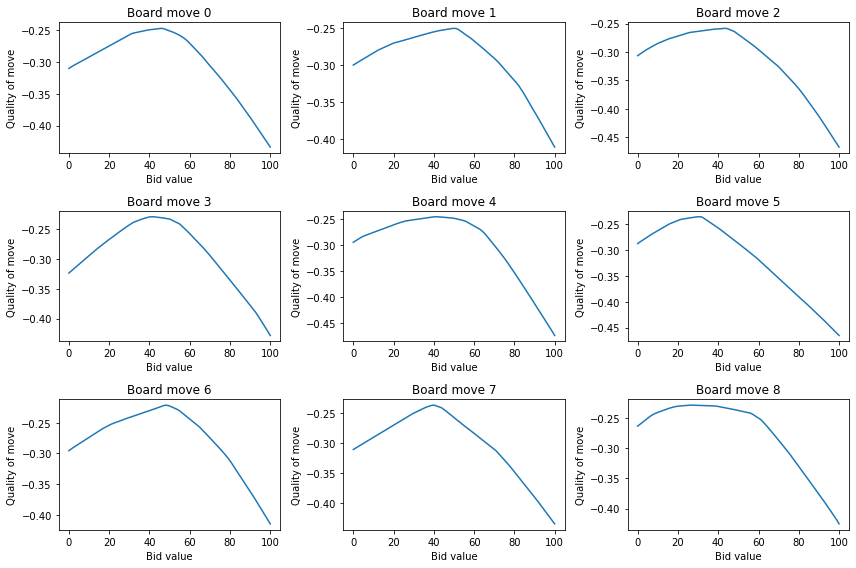

Animation of critic values saved!
Episode #20100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.66  |  Epsilon: 0.221
                  Actor Loss: -0.615  |  Critic Loss: +0.110     |  Time Elapsed: 9452.21s
Episode #20200  |  Val. Score: +0.30   |  Avg. Val. Score: +0.67  |  Epsilon: 0.220
                  Actor Loss: -0.587  |  Critic Loss: +0.143     |  Time Elapsed: 9504.33s
Episode #20300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.218
                  Actor Loss: -0.613  |  Critic Loss: +0.121     |  Time Elapsed: 9555.23s
Episode #20400  |  Val. Score: +0.50   |  Avg. Val. Score: +0.68  |  Epsilon: 0.217
                  Actor Loss: -0.620  |  Critic Loss: +0.126     |  Time Elapsed: 9604.91s
Episode #20500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.66  |  Epsilon: 0.215
                  Actor Loss: -0.608  |  Critic Loss: +0.118     |  Time Elapsed: 9655.81s
Checkpoint saved!
Episode #20600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.64  |  Epsi

Episode #24700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.157
                  Actor Loss: -0.610  |  Critic Loss: +0.120     |  Time Elapsed: 11736.94s
Episode #24800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.88  |  Epsilon: 0.156
                  Actor Loss: -0.575  |  Critic Loss: +0.132     |  Time Elapsed: 11785.29s
Episode #24900  |  Val. Score: +0.90   |  Avg. Val. Score: +0.87  |  Epsilon: 0.154
                  Actor Loss: -0.581  |  Critic Loss: +0.121     |  Time Elapsed: 11836.81s
Episode #25000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.153
                  Actor Loss: -0.584  |  Critic Loss: +0.117     |  Time Elapsed: 11888.15s
Checkpoint saved!
Episode #25100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.87  |  Epsilon: 0.152
                  Actor Loss: -0.576  |  Critic Loss: +0.122     |  Time Elapsed: 11936.48s
Episode #25200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.151
                  

Episode #29300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.82  |  Epsilon: 0.111
                  Actor Loss: -0.626  |  Critic Loss: +0.119     |  Time Elapsed: 14053.36s
Episode #29400  |  Val. Score: +0.70   |  Avg. Val. Score: +0.81  |  Epsilon: 0.110
                  Actor Loss: -0.597  |  Critic Loss: +0.117     |  Time Elapsed: 14104.98s
Episode #29500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.82  |  Epsilon: 0.109
                  Actor Loss: -0.640  |  Critic Loss: +0.106     |  Time Elapsed: 14156.05s
Checkpoint saved!
Episode #29600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.80  |  Epsilon: 0.109
                  Actor Loss: -0.584  |  Critic Loss: +0.120     |  Time Elapsed: 14205.88s
Episode #29700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.108
                  Actor Loss: -0.602  |  Critic Loss: +0.117     |  Time Elapsed: 14255.94s
Episode #29800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  |  Epsilon: 0.107
                  

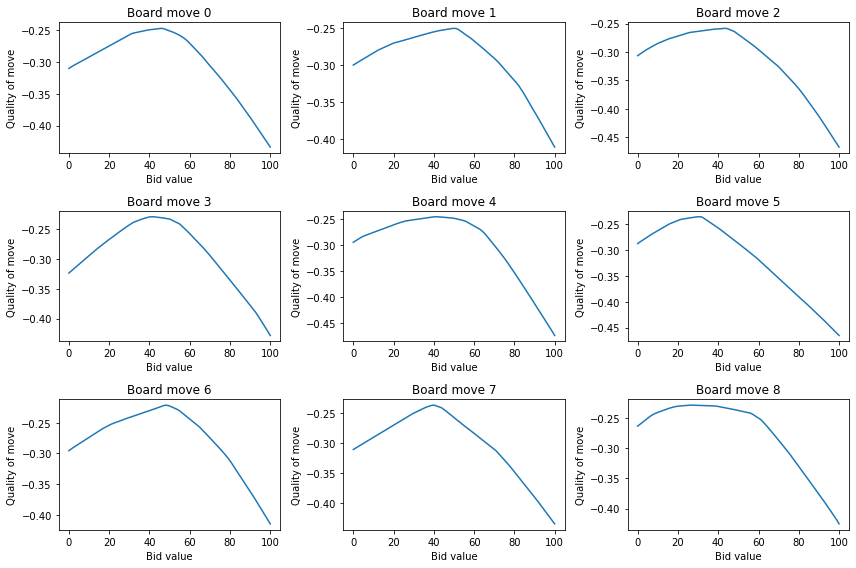

Animation of critic values saved!
Episode #30100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.105
                  Actor Loss: -0.584  |  Critic Loss: +0.118     |  Time Elapsed: 14473.01s
Episode #30200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.104
                  Actor Loss: -0.635  |  Critic Loss: +0.107     |  Time Elapsed: 14525.14s
Episode #30300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.84  |  Epsilon: 0.103
                  Actor Loss: -0.585  |  Critic Loss: +0.120     |  Time Elapsed: 14576.33s
Episode #30400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.102
                  Actor Loss: -0.585  |  Critic Loss: +0.111     |  Time Elapsed: 14627.04s
Episode #30500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.102
                  Actor Loss: -0.586  |  Critic Loss: +0.127     |  Time Elapsed: 14676.70s
Checkpoint saved!
Episode #30600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.83  | 

Episode #34700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.77  |  Epsilon: 0.074
                  Actor Loss: -0.636  |  Critic Loss: +0.119     |  Time Elapsed: 16850.05s
Episode #34800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.074
                  Actor Loss: -0.619  |  Critic Loss: +0.110     |  Time Elapsed: 16903.11s
Episode #34900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.77  |  Epsilon: 0.073
                  Actor Loss: -0.629  |  Critic Loss: +0.115     |  Time Elapsed: 16953.43s
Episode #35000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.072
                  Actor Loss: -0.635  |  Critic Loss: +0.116     |  Time Elapsed: 17004.94s
Checkpoint saved!
Episode #35100  |  Val. Score: +0.50   |  Avg. Val. Score: +0.74  |  Epsilon: 0.072
                  Actor Loss: -0.656  |  Critic Loss: +0.109     |  Time Elapsed: 17056.97s
Episode #35200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.78  |  Epsilon: 0.071
                  

Episode #39300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.052
                  Actor Loss: -0.622  |  Critic Loss: +0.102     |  Time Elapsed: 19283.96s
Episode #39400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.052
                  Actor Loss: -0.631  |  Critic Loss: +0.118     |  Time Elapsed: 19337.53s
Episode #39500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.052
                  Actor Loss: -0.629  |  Critic Loss: +0.115     |  Time Elapsed: 19390.31s
Checkpoint saved!
Episode #39600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.77  |  Epsilon: 0.051
                  Actor Loss: -0.616  |  Critic Loss: +0.100     |  Time Elapsed: 19443.16s
Episode #39700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.79  |  Epsilon: 0.051
                  Actor Loss: -0.626  |  Critic Loss: +0.111     |  Time Elapsed: 19496.55s
Episode #39800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.051
                  

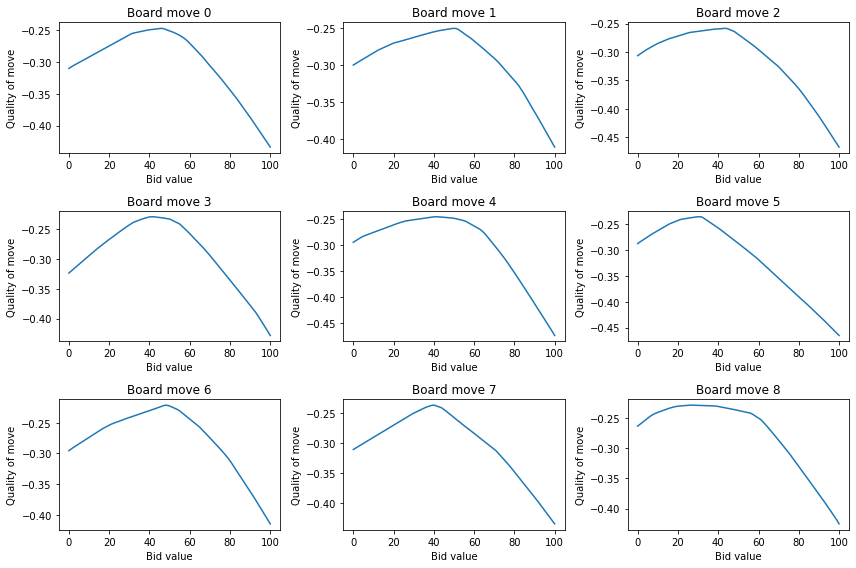

Animation of critic values saved!
Episode #40100  |  Val. Score: +0.50   |  Avg. Val. Score: +0.84  |  Epsilon: 0.049
                  Actor Loss: -0.614  |  Critic Loss: +0.120     |  Time Elapsed: 19725.28s
Episode #40200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.049
                  Actor Loss: -0.627  |  Critic Loss: +0.108     |  Time Elapsed: 19778.91s
Episode #40300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.82  |  Epsilon: 0.049
                  Actor Loss: -0.626  |  Critic Loss: +0.099     |  Time Elapsed: 19834.16s
Episode #40400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.82  |  Epsilon: 0.048
                  Actor Loss: -0.620  |  Critic Loss: +0.100     |  Time Elapsed: 19885.49s
Episode #40500  |  Val. Score: +0.90   |  Avg. Val. Score: +0.83  |  Epsilon: 0.048
                  Actor Loss: -0.613  |  Critic Loss: +0.120     |  Time Elapsed: 19938.36s
Checkpoint saved!
Episode #40600  |  Val. Score: +0.70   |  Avg. Val. Score: +0.80  | 

Episode #44700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.76  |  Epsilon: 0.035
                  Actor Loss: -0.634  |  Critic Loss: +0.105     |  Time Elapsed: 22188.23s
Episode #44800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.035
                  Actor Loss: -0.643  |  Critic Loss: +0.104     |  Time Elapsed: 22241.88s
Episode #44900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.034
                  Actor Loss: -0.640  |  Critic Loss: +0.112     |  Time Elapsed: 22295.91s
Episode #45000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.034
                  Actor Loss: -0.632  |  Critic Loss: +0.115     |  Time Elapsed: 22349.02s
Checkpoint saved!
Episode #45100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.034
                  Actor Loss: -0.674  |  Critic Loss: +0.117     |  Time Elapsed: 22401.68s
Episode #45200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.034
                  

Episode #49300  |  Val. Score: +0.90   |  Avg. Val. Score: +0.90  |  Epsilon: 0.025
                  Actor Loss: -0.646  |  Critic Loss: +0.105     |  Time Elapsed: 24681.48s
Episode #49400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.025
                  Actor Loss: -0.649  |  Critic Loss: +0.115     |  Time Elapsed: 24738.24s
Episode #49500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.90  |  Epsilon: 0.024
                  Actor Loss: -0.636  |  Critic Loss: +0.111     |  Time Elapsed: 24791.60s
Checkpoint saved!
Episode #49600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.024
                  Actor Loss: -0.657  |  Critic Loss: +0.114     |  Time Elapsed: 24843.85s
Episode #49700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.90  |  Epsilon: 0.024
                  Actor Loss: -0.634  |  Critic Loss: +0.113     |  Time Elapsed: 24896.59s
Episode #49800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.88  |  Epsilon: 0.024
                  

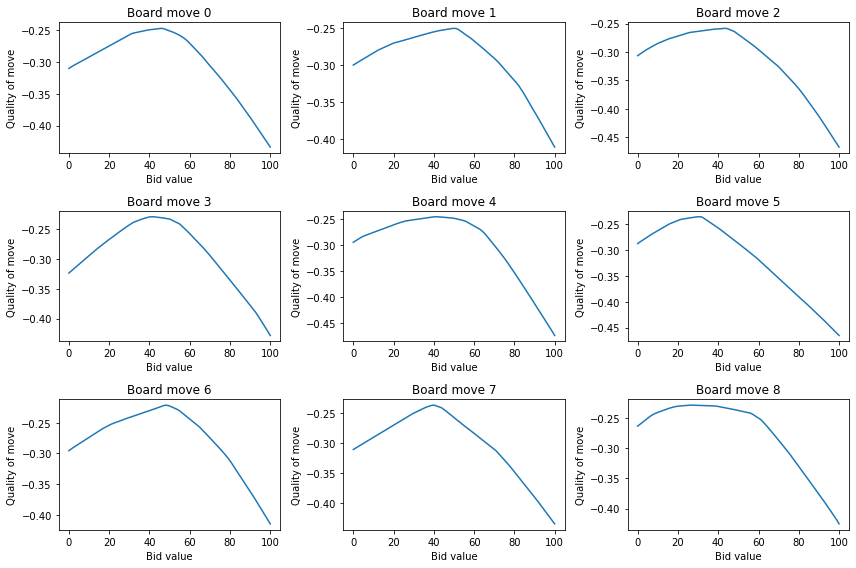

Animation of critic values saved!
Episode #50100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.023
                  Actor Loss: -0.643  |  Critic Loss: +0.113     |  Time Elapsed: 25140.87s
Episode #50200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.023
                  Actor Loss: -0.610  |  Critic Loss: +0.111     |  Time Elapsed: 25194.72s
Episode #50300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.83  |  Epsilon: 0.023
                  Actor Loss: -0.662  |  Critic Loss: +0.105     |  Time Elapsed: 25250.12s
Episode #50400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.023
                  Actor Loss: -0.644  |  Critic Loss: +0.111     |  Time Elapsed: 25306.94s
Episode #50500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.023
                  Actor Loss: -0.654  |  Critic Loss: +0.107     |  Time Elapsed: 25361.30s
Checkpoint saved!
Episode #50600  |  Val. Score: +0.50   |  Avg. Val. Score: +0.80  | 

Episode #54700  |  Val. Score: +0.90   |  Avg. Val. Score: +0.91  |  Epsilon: 0.017
                  Actor Loss: -0.682  |  Critic Loss: +0.120     |  Time Elapsed: 27689.13s
Episode #54800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.87  |  Epsilon: 0.016
                  Actor Loss: -0.673  |  Critic Loss: +0.125     |  Time Elapsed: 27745.01s
Episode #54900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.83  |  Epsilon: 0.016
                  Actor Loss: -0.671  |  Critic Loss: +0.113     |  Time Elapsed: 27799.97s
Episode #55000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.016
                  Actor Loss: -0.652  |  Critic Loss: +0.116     |  Time Elapsed: 27857.06s
Checkpoint saved!
Episode #55100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.016
                  Actor Loss: -0.681  |  Critic Loss: +0.111     |  Time Elapsed: 27915.60s
Episode #55200  |  Val. Score: +0.90   |  Avg. Val. Score: +0.86  |  Epsilon: 0.016
                  

Episode #59300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.012
                  Actor Loss: -0.662  |  Critic Loss: +0.120     |  Time Elapsed: 30296.35s
Episode #59400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.012
                  Actor Loss: -0.653  |  Critic Loss: +0.118     |  Time Elapsed: 30354.67s
Episode #59500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.012
                  Actor Loss: -0.668  |  Critic Loss: +0.112     |  Time Elapsed: 30409.95s
Checkpoint saved!
Episode #59600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.011
                  Actor Loss: -0.642  |  Critic Loss: +0.107     |  Time Elapsed: 30467.08s
Episode #59700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.87  |  Epsilon: 0.011
                  Actor Loss: -0.644  |  Critic Loss: +0.115     |  Time Elapsed: 30525.55s
Episode #59800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.011
                  

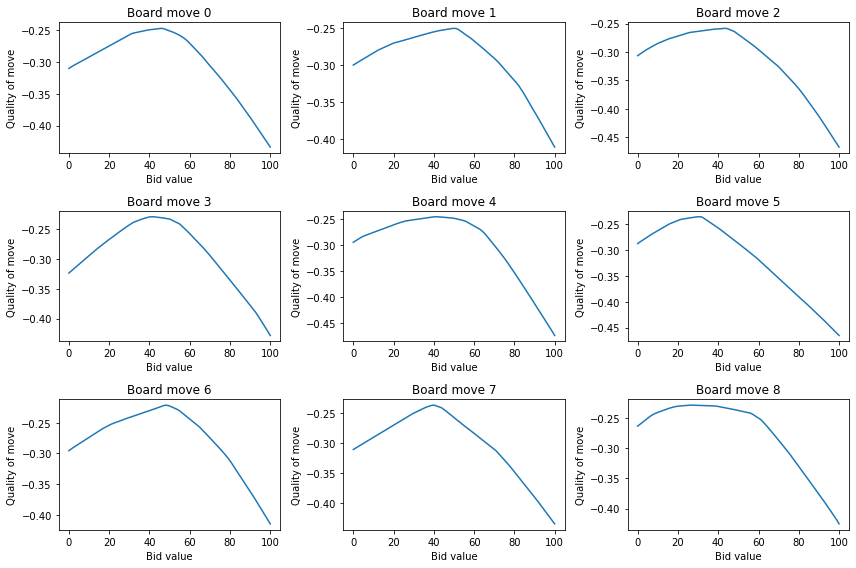

Animation of critic values saved!
Episode #60100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.011
                  Actor Loss: -0.673  |  Critic Loss: +0.104     |  Time Elapsed: 30779.56s
Episode #60200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.92  |  Epsilon: 0.011
                  Actor Loss: -0.678  |  Critic Loss: +0.114     |  Time Elapsed: 30838.77s
Episode #60300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.011
                  Actor Loss: -0.678  |  Critic Loss: +0.105     |  Time Elapsed: 30897.93s
Episode #60400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.011
                  Actor Loss: -0.659  |  Critic Loss: +0.117     |  Time Elapsed: 30955.53s
Episode #60500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.011
                  Actor Loss: -0.682  |  Critic Loss: +0.102     |  Time Elapsed: 31015.20s
Checkpoint saved!
Episode #60600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.90  | 

Episode #64700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.660  |  Critic Loss: +0.127     |  Time Elapsed: 33463.11s
Episode #64800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.661  |  Critic Loss: +0.105     |  Time Elapsed: 33519.72s
Episode #64900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.673  |  Critic Loss: +0.124     |  Time Elapsed: 33577.04s
Episode #65000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.663  |  Critic Loss: +0.116     |  Time Elapsed: 33637.85s
Checkpoint saved!
Episode #65100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.685  |  Critic Loss: +0.090     |  Time Elapsed: 33699.29s
Episode #65200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  

Episode #69300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.662  |  Critic Loss: +0.098     |  Time Elapsed: 36218.77s
Episode #69400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.102     |  Time Elapsed: 36280.14s
Episode #69500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.657  |  Critic Loss: +0.115     |  Time Elapsed: 36344.55s
Checkpoint saved!
Episode #69600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.675  |  Critic Loss: +0.103     |  Time Elapsed: 36404.94s
Episode #69700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.667  |  Critic Loss: +0.110     |  Time Elapsed: 36467.63s
Episode #69800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  

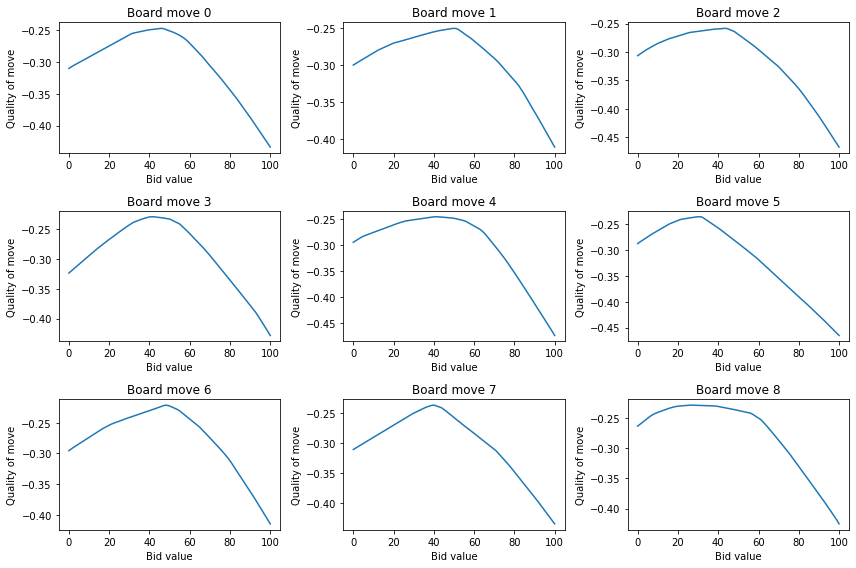

Animation of critic values saved!
Episode #70100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.670  |  Critic Loss: +0.100     |  Time Elapsed: 36744.05s
Episode #70200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.683  |  Critic Loss: +0.111     |  Time Elapsed: 36805.32s
Episode #70300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.683  |  Critic Loss: +0.110     |  Time Elapsed: 36866.83s
Episode #70400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.688  |  Critic Loss: +0.098     |  Time Elapsed: 36927.98s
Episode #70500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.010
                  Actor Loss: -0.640  |  Critic Loss: +0.118     |  Time Elapsed: 36989.96s
Checkpoint saved!
Episode #70600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.92  | 

Episode #74700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.010
                  Actor Loss: -0.677  |  Critic Loss: +0.104     |  Time Elapsed: 39609.88s
Episode #74800  |  Val. Score: +0.90   |  Avg. Val. Score: +0.93  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.119     |  Time Elapsed: 39673.81s
Episode #74900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.93  |  Epsilon: 0.010
                  Actor Loss: -0.660  |  Critic Loss: +0.110     |  Time Elapsed: 39737.80s
Episode #75000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.93  |  Epsilon: 0.010
                  Actor Loss: -0.696  |  Critic Loss: +0.115     |  Time Elapsed: 39802.29s
Checkpoint saved!
Episode #75100  |  Val. Score: +0.90   |  Avg. Val. Score: +0.94  |  Epsilon: 0.010
                  Actor Loss: -0.686  |  Critic Loss: +0.097     |  Time Elapsed: 39866.29s
Episode #75200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.96  |  Epsilon: 0.010
                  

Episode #79300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.665  |  Critic Loss: +0.106     |  Time Elapsed: 42552.88s
Episode #79400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.650  |  Critic Loss: +0.108     |  Time Elapsed: 42618.43s
Episode #79500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.672  |  Critic Loss: +0.113     |  Time Elapsed: 42683.22s
Checkpoint saved!
Episode #79600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.682  |  Critic Loss: +0.095     |  Time Elapsed: 42742.18s
Episode #79700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.010
                  Actor Loss: -0.667  |  Critic Loss: +0.109     |  Time Elapsed: 42805.07s
Episode #79800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.010
                  

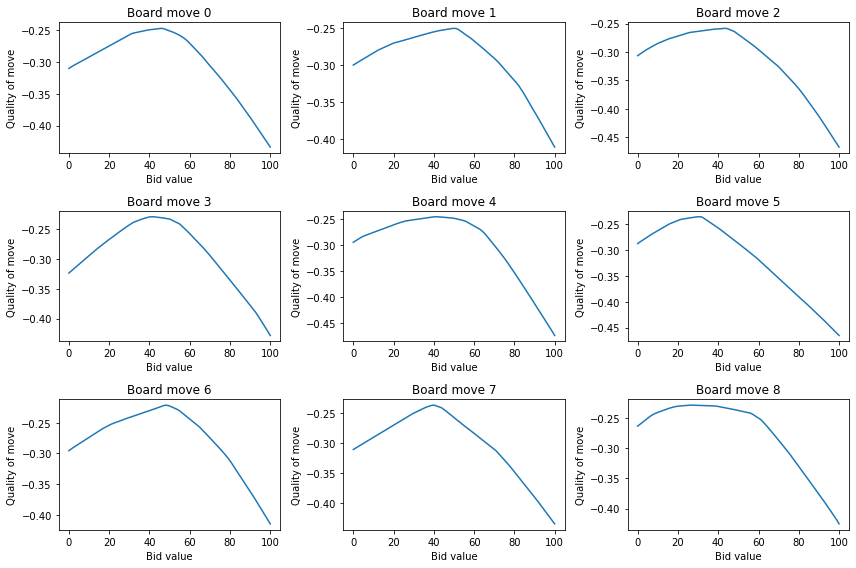

Animation of critic values saved!
Episode #80100  |  Val. Score: +0.90   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.688  |  Critic Loss: +0.092     |  Time Elapsed: 43090.88s
Episode #80200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.97  |  Epsilon: 0.010
                  Actor Loss: -0.698  |  Critic Loss: +0.110     |  Time Elapsed: 43152.12s
Episode #80300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.93  |  Epsilon: 0.010
                  Actor Loss: -0.695  |  Critic Loss: +0.108     |  Time Elapsed: 43218.46s
Episode #80400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.93  |  Epsilon: 0.010
                  Actor Loss: -0.684  |  Critic Loss: +0.096     |  Time Elapsed: 43283.02s
Episode #80500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.93  |  Epsilon: 0.010
                  Actor Loss: -0.675  |  Critic Loss: +0.113     |  Time Elapsed: 43350.43s
Checkpoint saved!
Episode #80600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.93  | 

Episode #84700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.684  |  Critic Loss: +0.097     |  Time Elapsed: 46145.03s
Episode #84800  |  Val. Score: +0.90   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.672  |  Critic Loss: +0.096     |  Time Elapsed: 46212.52s
Episode #84900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.687  |  Critic Loss: +0.101     |  Time Elapsed: 46280.59s
Episode #85000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.673  |  Critic Loss: +0.103     |  Time Elapsed: 46349.20s
Checkpoint saved!
Episode #85100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.665  |  Critic Loss: +0.116     |  Time Elapsed: 46418.38s
Episode #85200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  

Episode #89300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.672  |  Critic Loss: +0.111     |  Time Elapsed: 49293.00s
Episode #89400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.672  |  Critic Loss: +0.102     |  Time Elapsed: 49359.99s
Episode #89500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.688  |  Critic Loss: +0.097     |  Time Elapsed: 49428.82s
Checkpoint saved!
Episode #89600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.111     |  Time Elapsed: 49499.64s
Episode #89700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.670  |  Critic Loss: +0.113     |  Time Elapsed: 49569.41s
Episode #89800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.92  |  Epsilon: 0.010
                  

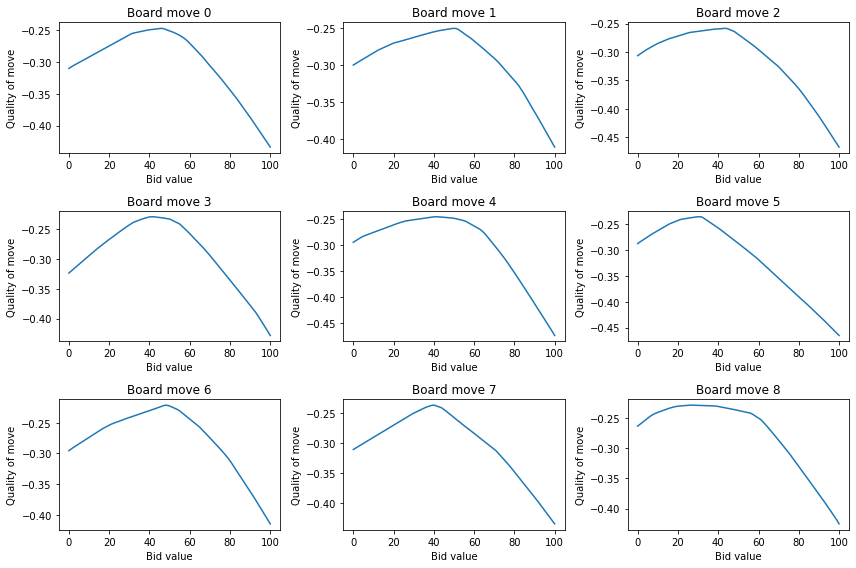

Animation of critic values saved!
Episode #90100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.677  |  Critic Loss: +0.097     |  Time Elapsed: 49885.04s
Episode #90200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.97  |  Epsilon: 0.010
                  Actor Loss: -0.679  |  Critic Loss: +0.104     |  Time Elapsed: 49953.79s
Episode #90300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.97  |  Epsilon: 0.010
                  Actor Loss: -0.687  |  Critic Loss: +0.114     |  Time Elapsed: 50024.18s
Episode #90400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.99  |  Epsilon: 0.010
                  Actor Loss: -0.669  |  Critic Loss: +0.110     |  Time Elapsed: 50093.76s
Episode #90500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.99  |  Epsilon: 0.010
                  Actor Loss: -0.653  |  Critic Loss: +0.108     |  Time Elapsed: 50162.85s
Checkpoint saved!
Episode #90600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.97  | 

Episode #94700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.674  |  Critic Loss: +0.098     |  Time Elapsed: 53135.74s
Episode #94800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.098     |  Time Elapsed: 53208.51s
Episode #94900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.687  |  Critic Loss: +0.099     |  Time Elapsed: 53283.11s
Episode #95000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.672  |  Critic Loss: +0.125     |  Time Elapsed: 53353.47s
Checkpoint saved!
Episode #95100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.697  |  Critic Loss: +0.107     |  Time Elapsed: 53429.42s
Episode #95200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  

Episode #99300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.106     |  Time Elapsed: 56474.20s
Episode #99400  |  Val. Score: +0.70   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.674  |  Critic Loss: +0.090     |  Time Elapsed: 56550.15s
Episode #99500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.682  |  Critic Loss: +0.108     |  Time Elapsed: 56623.68s
Checkpoint saved!
Episode #99600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.696  |  Critic Loss: +0.098     |  Time Elapsed: 56696.70s
Episode #99700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.660  |  Critic Loss: +0.110     |  Time Elapsed: 56771.89s
Episode #99800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  

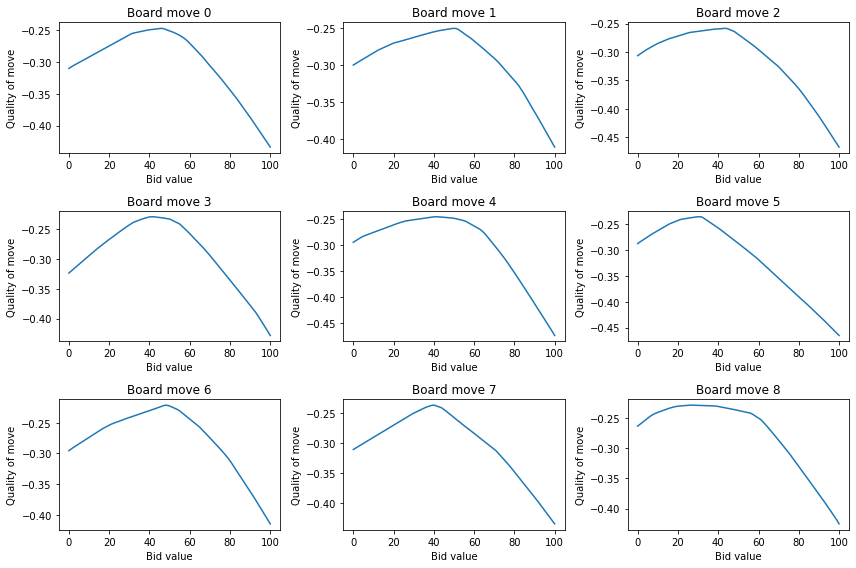

Animation of critic values saved!
Model saved!


In [11]:
n_episodes=100000
checkpoint_each=500
validate_each=100
n_episodes_validation=10
save_critic_value_each=1000
save_animation_each=10000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.999925
players = [
    DRLPlayer(0, controller.game, drl_agent, train_mode=True),
]
if TRAIN_MODE == 'self_play':
    players.append(DRLPlayer(1, controller.game, drl_agent, train_mode=True))
elif TRAIN_MODE == 'random':
    players.append(RandomPlayer(1))
elif TRAIN_MODE == 'semi_random':
    players.append(SemiRandomPlayer(1, controller.game))
validation_scores, critic_values_by_episode = init_train(controller, players, model_path=f'../checkpoints/{MODEL_VERSION}_model.pt',
                    n_episodes=n_episodes, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)


In [12]:
len(critic_values_by_episode)

100

In [13]:
final_validation_scores = validation_scores
final_critic_values_by_episode = critic_values_by_episode

Episode #100100  |  Val. Score: +0.90   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.689  |  Critic Loss: +0.100     |  Time Elapsed: 71.33s
Episode #100200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.650  |  Critic Loss: +0.106     |  Time Elapsed: 143.61s
Episode #100300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.97  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.103     |  Time Elapsed: 214.95s
Episode #100400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.97  |  Epsilon: 0.010
                  Actor Loss: -0.677  |  Critic Loss: +0.113     |  Time Elapsed: 289.80s
Episode #100500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.98  |  Epsilon: 0.010
                  Actor Loss: -0.687  |  Critic Loss: +0.099     |  Time Elapsed: 364.16s
Checkpoint saved!
Episode #100600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.98  |  Epsilon: 0.010
                  Actor

Episode #104700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.93  |  Epsilon: 0.010
                  Actor Loss: -0.708  |  Critic Loss: +0.090     |  Time Elapsed: 3620.79s
Episode #104800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.671  |  Critic Loss: +0.102     |  Time Elapsed: 3704.77s
Episode #104900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.672  |  Critic Loss: +0.104     |  Time Elapsed: 3790.86s
Episode #105000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.683  |  Critic Loss: +0.116     |  Time Elapsed: 3873.33s
Checkpoint saved!
Episode #105100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.684  |  Critic Loss: +0.099     |  Time Elapsed: 3959.71s
Episode #105200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.80  |  Epsilon: 0.010
                 

Episode #109300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.708  |  Critic Loss: +0.099     |  Time Elapsed: 7541.24s
Episode #109400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.712  |  Critic Loss: +0.094     |  Time Elapsed: 7623.78s
Episode #109500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.668  |  Critic Loss: +0.115     |  Time Elapsed: 7709.54s
Checkpoint saved!
Episode #109600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.674  |  Critic Loss: +0.120     |  Time Elapsed: 7793.02s
Episode #109700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.679  |  Critic Loss: +0.111     |  Time Elapsed: 7875.66s
Episode #109800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                 

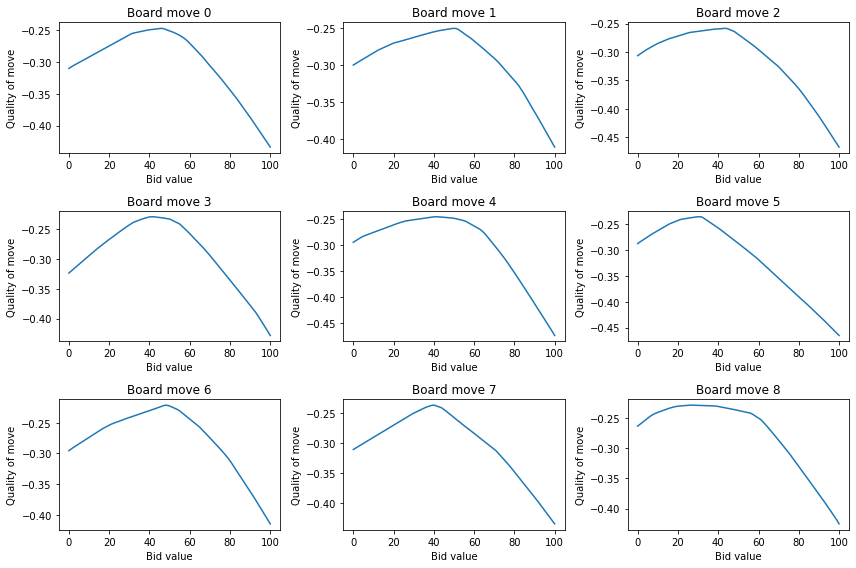

Animation of critic values saved!
Episode #110100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.697  |  Critic Loss: +0.097     |  Time Elapsed: 8253.81s
Episode #110200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.694  |  Critic Loss: +0.100     |  Time Elapsed: 8338.26s
Episode #110300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.686  |  Critic Loss: +0.107     |  Time Elapsed: 8420.76s
Episode #110400  |  Val. Score: +0.90   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.693  |  Critic Loss: +0.102     |  Time Elapsed: 8502.17s
Episode #110500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.106     |  Time Elapsed: 8585.21s
Checkpoint saved!
Episode #110600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |

Episode #114700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.734  |  Critic Loss: +0.096     |  Time Elapsed: 12194.98s
Episode #114800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.726  |  Critic Loss: +0.095     |  Time Elapsed: 12279.58s
Episode #114900  |  Val. Score: +0.10   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.703  |  Critic Loss: +0.096     |  Time Elapsed: 12365.11s
Episode #115000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.80  |  Epsilon: 0.010
                  Actor Loss: -0.729  |  Critic Loss: +0.085     |  Time Elapsed: 12450.61s
Checkpoint saved!
Episode #115100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.707  |  Critic Loss: +0.081     |  Time Elapsed: 12535.25s
Episode #115200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
            

Episode #119300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.097     |  Time Elapsed: 16233.67s
Episode #119400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.677  |  Critic Loss: +0.115     |  Time Elapsed: 16317.64s
Episode #119500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.670  |  Critic Loss: +0.094     |  Time Elapsed: 16400.23s
Checkpoint saved!
Episode #119600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.641  |  Critic Loss: +0.099     |  Time Elapsed: 16485.36s
Episode #119700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.693  |  Critic Loss: +0.096     |  Time Elapsed: 16572.37s
Episode #119800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
            

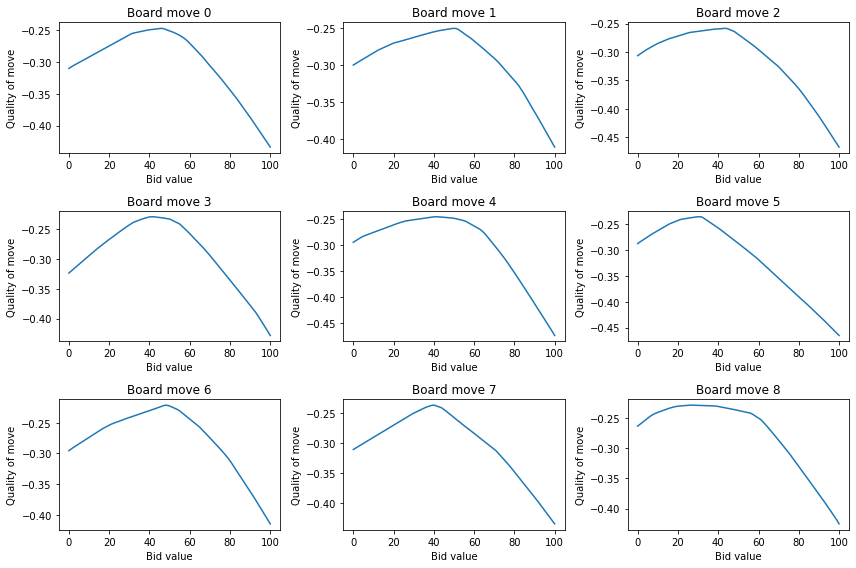

Animation of critic values saved!
Episode #120100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.672  |  Critic Loss: +0.101     |  Time Elapsed: 16958.25s
Episode #120200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.677  |  Critic Loss: +0.097     |  Time Elapsed: 17046.13s
Episode #120300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.670  |  Critic Loss: +0.106     |  Time Elapsed: 17131.02s
Episode #120400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.635  |  Critic Loss: +0.111     |  Time Elapsed: 17215.23s
Episode #120500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.681  |  Critic Loss: +0.112     |  Time Elapsed: 17302.24s
Checkpoint saved!
Episode #120600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.

Episode #124700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.689  |  Critic Loss: +0.101     |  Time Elapsed: 21091.85s
Episode #124800  |  Val. Score: +0.70   |  Avg. Val. Score: +0.80  |  Epsilon: 0.010
                  Actor Loss: -0.648  |  Critic Loss: +0.105     |  Time Elapsed: 21186.96s
Episode #124900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.76  |  Epsilon: 0.010
                  Actor Loss: -0.660  |  Critic Loss: +0.113     |  Time Elapsed: 21281.04s


In [ ]:
# Continue training
validation_scores_continued, critic_values_by_episode_continued = init_train(controller, players,
                    start_epoch=100001, critic_values_by_episode=critic_values_by_episode, model_path=f'../checkpoints/{MODEL_VERSION}_model.pt',
                    n_episodes=50000, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=0.01, eps_end=eps_end, eps_decay=eps_decay)

In [ ]:
final_validation_scores += validation_scores_continued
final_critic_values_by_episode += critic_values_by_episode_continued

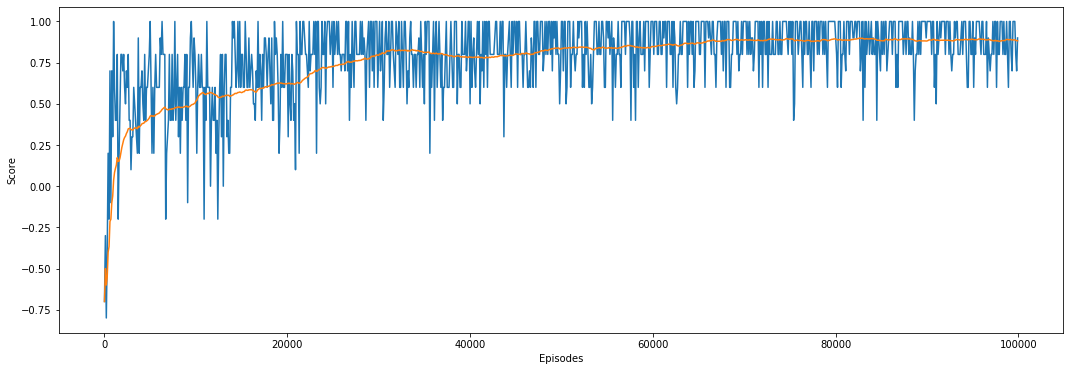

In [16]:
plot_scores(final_validation_scores, validate_each)

In [17]:
drl_agent.save_model(f'../checkpoints/{MODEL_VERSION}_model_final.pt')

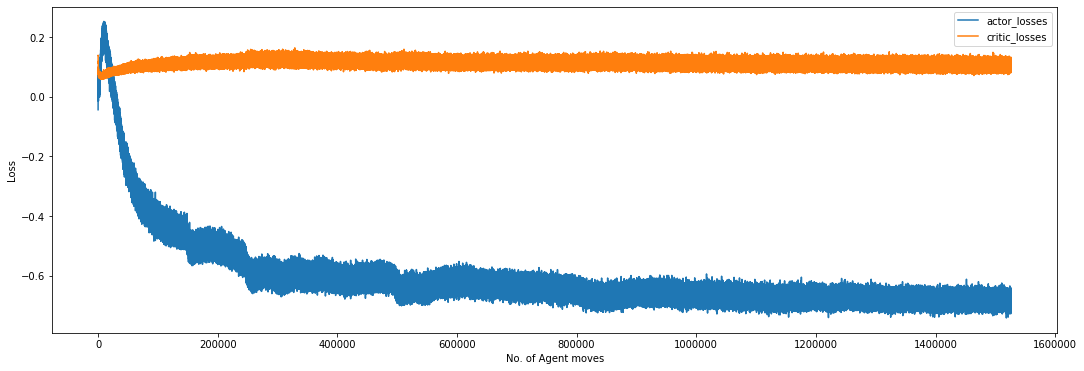

In [18]:
# Plot loss functions
losses = drl_agent.get_losses()
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(losses['actor_losses'], label='actor_losses')
ax.plot(losses['critic_losses'], label='critic_losses')
ax.set_xlabel('No. of Agent moves')
ax.set_ylabel('Loss')
# ax.plot(list((critic_loss - actor_loss) for critic_loss, actor_loss in zip(losses['critic_losses'][:], losses['actor_losses'][:])), label='diff_losses')
plt.legend(loc='best')
plt.show();

In [19]:
# controller.reset_game(drl_checkpoint_path=f'../checkpoints/{MODEL_VERSION}_model.pt')

In [20]:
run_validation(players, 1000)

0.887